<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
import string
ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
MAX_HIGHT = 128
MAX_WIDTH = 256



In [3]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
### Converting Chars to nums is better for ML
#Dont use @ in the alphabet. if you need you need to change the fillup char
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
alphabets = string.digits + string.ascii_letters + '!?.-() '
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels
batch_size = 1

def label_to_num(label):
    #fills up the label with @
    label = label.ljust(max_str_len, '@')
    label_num = []
    for ch in label:
      label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else -1)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret


(26, 70)


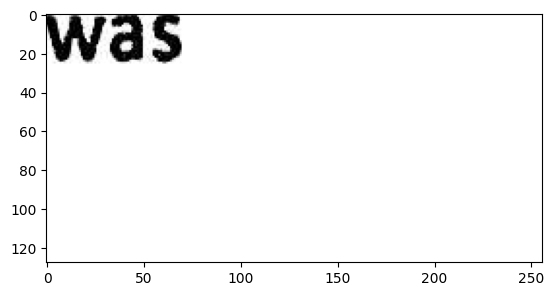

In [5]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images
def preprocess(img):

    (h, w) = img.shape


    #Scale all Images down that image width is max_width
    scaleFactor = MAX_WIDTH / w
    if scaleFactor < 1:
      img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
      (h, w) = img.shape

    #creates blank white image with size max_hight x max_width
    final_img = np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # if hight is still greater than max_hight, scale only hight down to max_hight
    if h > MAX_HIGHT:
       img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))


    # fills the blank image with resized imput image
    final_img[:h, :w] = img
    return final_img

imgPath = os.path.join(ImgFolder, "11.png")
image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(preprocess(image),cmap='gray')

In [20]:
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor

#Reading the json {Image_filename, "test on Image"}
with open('/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json') as f:
    data = list(json.load(f).items())

#Reduced to just 500, change it to all for real training
keyVal = np.array(data[:500])
y_all = keyVal[:,1]
x_all_img_path = keyVal[:,0]


def load_image(imgName):
  imgPath = ImgFolder+imgName
  entry = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
  print("loaded:  " + imgName)
  return preprocess(entry)



#Reading all Images and put into a np array

images = []
with ThreadPoolExecutor() as executor:
    results = executor.map(lambda path: load_image(path), x_all_img_path)
    for result in results:
        if result is not None:
            images.append(result)

x_all = np.array(images)

print(x_all.shape)
print(type(x_all))

loaded:  1.jpeg
loaded:  2.jpeg
loaded:  0.jpeg
loaded:  8.jpeg
loaded:  4.pngloaded:  5.png
loaded:  6.jpeg
loaded:  3.jpeg
loaded:  7.jpeg

loaded:  9.png
loaded:  11.png
loaded:  12.jpeg
loaded:  13.png
loaded:  15.jpeg
loaded:  14.png
loaded:  10.png
loaded:  16.jpeg
loaded:  17.png
loaded:  18.jpeg
loaded:  19.jpeg
loaded:  20.jpeg
loaded:  21.jpeg
loaded:  22.jpeg
loaded:  23.jpeg
loaded:  24.jpeg
loaded:  25.png
loaded:  26.jpeg
loaded:  28.png
loaded:  29.png
loaded:  30.jpeg
loaded:  27.png
loaded:  31.png
loaded:  32.png
loaded:  33.jpeg
loaded:  34.png
loaded:  35.png
loaded:  37.png
loaded:  38.jpeg
loaded:  36.png
loaded:  39.jpeg
loaded:  40.png
loaded:  41.jpeg
loaded:  42.png
loaded:  43.jpeg
loaded:  44.png
loaded:  45.jpeg
loaded:  46.jpeg
loaded:  47.png
loaded:  48.jpeg
loaded:  49.png
loaded:  50.jpeg
loaded:  51.jpeg
loaded:  52.jpeg
loaded:  53.png
loaded:  54.jpeg
loaded:  55.jpeg
loaded:  56.jpeg
loaded:  57.jpeg
loaded:  58.png
loaded:  59.jpeg
loaded:  60.jpe

In [21]:
def rotateImage(Image):
  return cv2.rotate(Image, cv2.ROTATE_90_CLOCKWISE)

In [45]:
#Convert Char Labels to num Labels
y_all_numbers = np.array([label_to_num(xi) for xi in y_all])

#rotate that x = Width and y = hight
x_all_rotate = np.array([rotateImage(xi) for xi in x_all])

#and reshape
x_train_rotate_reshaped = np.array(x_all_rotate).reshape(-1, MAX_WIDTH, MAX_HIGHT, 1)

In [48]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_rotate_reshaped, y_all_numbers, test_size=0.2, random_state=42)

# Print as sanity check
print(y_train[3])
num_to_label(y_train[3])

[28 25 14 12 18 10 21 29 34 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


'specialty'

In [ ]:
input_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
label_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
data_set = [x_train, y_train,input_length, label_length]
print(len(y_all_numbers))
print(x_train_rotate_reshaped[1].shape)

In [49]:
x_train[0].shape

(256, 128, 1)

should


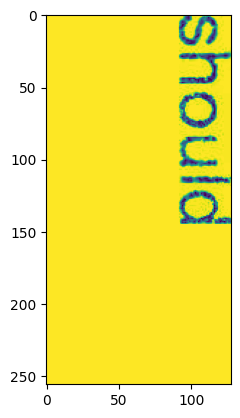

In [25]:
print(num_to_label(y_all_numbers[455]))
plt.imshow(x_all_rotate[455])
plt.show()

#Building the Model

In [54]:

# Evtl. Input umformatieren in einzeilig
input_data = Input(shape=(MAX_WIDTH, MAX_HIGHT, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 128, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 128, 32)      128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 256, 128, 32)      0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 64, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 64, 64)       18496     
                                                           

In [55]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



In [56]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
input_length

<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'input_length')>

In [57]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

In [51]:
x_train.shape

(400, 256, 128, 1)

In [58]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model_final.fit(data_set,
                 epochs=8, batch_size = 1,
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])


Epoch 1/8


ValueError: Target data is missing. Your model was compiled with loss={'ctc': <function <lambda> at 0x78b4f0ffe0e0>}, and therefore expects target data to be provided in `fit()`.